In [484]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

import tensorflow as tf

In [313]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [314]:
DATA_DIR = 'data/'
image_size = 256
batch_size = 32

### 1. Pre-processing

In [315]:
# read data to dataframe
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')
df.shape

(112120, 12)

In [316]:
# clean up the column names
df = df.rename(columns = {'Image Index' : 'image_index', 'Finding Labels': 'finding_labels',
                             'Follow-up #':'follow_up', 'Patient ID': 'patient_id', 'Patient Age':'patient_age',
                             'Patient Gender':'patient_gender', 'View Position':'view_position', 
                              'OriginalImage[Width':'orig_img_width', 'Height]':'orig_img_height',
                             'OriginalImagePixelSpacing[x':'pixel_spacing_x', 'y]':'pixel_spacing_y',
                             'Unnamed: 11':'unnamed_11'})

Since the image paths are listed without folder names, need to add full paths

In [318]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', 'images', '*png'))}
df['image_path'] = df['image_index'].map(data_image_paths.get)
del df['image_index']

In [319]:
Some more preprocessing

In [320]:
# evade using spaces
df['finding_labels'] = df['finding_labels'].map(lambda x: x.replace('No Finding', 'No_Finding'))

In [321]:
# add column to stratify on
new = df["finding_labels"].str.split('|', n=1, expand=True)
df['disease'] = new[0]
df[['finding_labels', 'disease']].head(10)

,finding_labels,disease
0,Cardiomegaly,Cardiomegaly
1,Cardiomegaly|Emphysema,Cardiomegaly
2,Cardiomegaly|Effusion,Cardiomegaly
3,No_Finding,No_Finding
4,Hernia,Hernia
5,Hernia,Hernia
6,Hernia,Hernia
7,Hernia|Infiltration,Hernia
8,Hernia,Hernia
9,Hernia,Hernia


In [322]:
# extract labels
diseases = df.disease.unique().tolist()

### 2. Split the dataset.

In order to balance the dataset, I'll get rid of most of the samples from classes with too many samples. That's why I split the dataset with 90/10 proportions, because most of the training data will be thrown away.

In [344]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state = 2020, stratify=df['disease'])

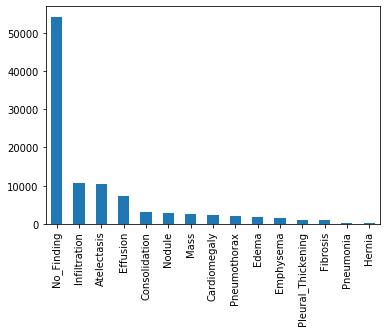

In [345]:
train_df.disease.value_counts().plot(kind='bar')

In [346]:
train_df.disease.value_counts()

No_Finding            54325
Infiltration          10615
Atelectasis           10390
Effusion               7236
Consolidation          2998
Nodule                 2708
Mass                   2633
Cardiomegaly           2164
Pneumothorax           1980
Edema                  1676
Emphysema              1561
Pleural_Thickening     1095
Fibrosis               1094
Pneumonia               293
Hernia                  140
Name: disease, dtype: int64

Balancing the dataset.

Remove more samples from classes that have >5000 samples,

Remove less samples from classes that have >1000 samples.

Don't remove samples that contain Pneumonia (as a comorbidity)

In [427]:
def drop_indices(df, column, label, drop=0.9, second_drop=0.8, 
                        first_count = 5000, second_count=1000):
    count = df[df[column] == label].shape[0]
    if(count > first_count):
        count_for_drop = int(count * drop)
        df = df.drop(df[((df[column] == label) & (df['Pneumonia'] == 0))][column].sample(count_for_drop).index)
    elif(count > second_count):
        drop = second_drop
        count_for_drop = int(count * drop)
        df = df.drop(df[((df[column] == label) & (df['Pneumonia'] == 0))][column].sample(count_for_drop).index)
    return df

In [348]:
# drop No-findings first
train_df = drop_indices(train_df, 'disease', 'No_Finding', 0.8)

In [349]:
train_df.disease.value_counts()

No_Finding            10865
Infiltration          10615
Atelectasis           10390
Effusion               7236
Consolidation          2998
Nodule                 2708
Mass                   2633
Cardiomegaly           2164
Pneumothorax           1980
Edema                  1676
Emphysema              1561
Pleural_Thickening     1095
Fibrosis               1094
Pneumonia               293
Hernia                  140
Name: disease, dtype: int64

In [350]:
# now remove some samples from all the classes with 1000 and more samples
for disease in diseases:
    train_df = drop_indices(train_df, 'disease', disease)

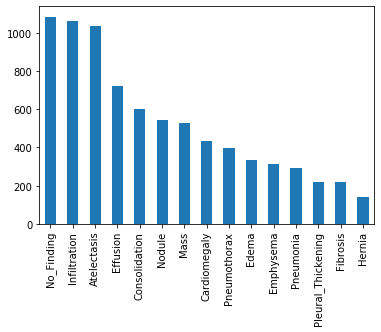

In [351]:
train_df.disease.value_counts().plot(kind='bar')

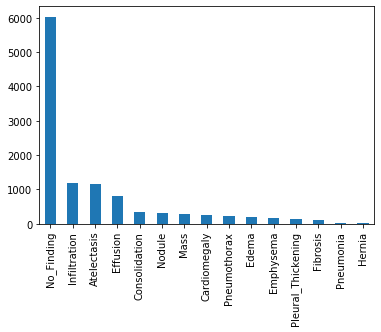

In [352]:
valid_df.disease.value_counts().plot(kind='bar')

In [353]:
valid_df.disease.value_counts()

No_Finding            6036
Infiltration          1180
Atelectasis           1155
Effusion               804
Consolidation          333
Nodule                 301
Mass                   293
Cardiomegaly           240
Pneumothorax           220
Edema                  186
Emphysema              173
Pleural_Thickening     122
Fibrosis               121
Pneumonia               32
Hernia                  16
Name: disease, dtype: int64

Validation dataset seems more balanced, but in order to pay more attention on samples with pneumonia, I'll also remove some samples from this dataset.

In [355]:
# drop No-findings first
valid_df = drop_indices(valid_df, 'disease', 'No_Finding', 0.8)

In [356]:
valid_df.disease.value_counts()

No_Finding            1208
Infiltration          1180
Atelectasis           1155
Effusion               804
Consolidation          333
Nodule                 301
Mass                   293
Cardiomegaly           240
Pneumothorax           220
Edema                  186
Emphysema              173
Pleural_Thickening     122
Fibrosis               121
Pneumonia               32
Hernia                  16
Name: disease, dtype: int64

In [428]:
# now remove some samples from all the classes with 1000 and more samples
for disease in diseases:
    valid_df = drop_indices(valid_df, 'disease', disease, second_drop=0.5, first_count=500, second_count=100)

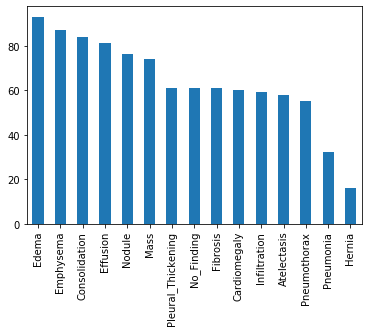

In [429]:
valid_df.disease.value_counts().plot(kind='bar')

In [359]:
valid_df.disease.value_counts()

Consolidation         167
Nodule                151
Mass                  147
No_Finding            121
Cardiomegaly          120
Infiltration          118
Atelectasis           116
Pneumothorax          110
Edema                  93
Emphysema              87
Effusion               81
Pleural_Thickening     61
Fibrosis               61
Pneumonia              32
Hernia                 16
Name: disease, dtype: int64

Now, validation set looks more balanced too.

### 3. Add image generators for data augmentation

In [360]:
train_df = train_df.assign(labels = train_df['finding_labels'].str.split('|'))
valid_df = valid_df.assign(labels = valid_df['finding_labels'].str.split('|'))

In [394]:
with tf.device('/GPU:0'):
    train_idg = ImageDataGenerator(rescale                         = 1/255,
                                      samplewise_center            = True,
                                      samplewise_std_normalization = True,
                                      horizontal_flip              = True,
                                      vertical_flip                = False,
                                      height_shift_range           = 0.05,
                                      width_shift_range            = 0.1,
                                      rotation_range               = 5,
                                      shear_range                  = 0.1,
                                      fill_mode                    = 'reflect',
                                      zoom_range                   = 0.15)
    
    valid_idg = ImageDataGenerator(rescale                     = 1/255,
                                  samplewise_center            = True,
                                  samplewise_std_normalization = True)

    train_gen = train_idg.flow_from_dataframe(dataframe=train_df,
                                                 directory=None,
                                                 x_col='image_path',
                                                 y_col='labels',
                                                 class_mode='categorical',
                                                 batch_size=batch_size,
                                                 classes=diseases,
                                                 target_size=(image_size, image_size))

    valid_gen = valid_idg.flow_from_dataframe(dataframe=valid_df,
                                                 directory=None,
                                                 x_col='image_path',
                                                 y_col='labels',
                                                 class_mode='categorical',
                                                 batch_size=batch_size,
                                                 classes=diseases,
                                                 target_size=(image_size, image_size))

    test_X, test_Y = next(valid_idg.flow_from_dataframe(dataframe=valid_df,
                                                           directory=None,
                                                           x_col='image_path',
                                                           y_col='labels',
                                                           class_mode='categorical',
                                                           batch_size=1024,
                                                           classes=diseases,
                                                           target_size=(image_size, image_size)))

Found 7930 validated image filenames belonging to 15 classes.
Found 1481 validated image filenames belonging to 15 classes.
Found 1481 validated image filenames belonging to 15 classes.


### 4. Load and train the model.

I choose inceptionResNetV2 as the best model currently available in the keras.application package. I also choose to retrain the entire model on the x-rays data.   

In [407]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(diseases), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [408]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=0, profile_batch = 100000000)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    callbacks.append(checkpoint)
    return callbacks

In [409]:
# set higher weight for pneumonia
class_weights = [1 for disease in diseases]
class_weights[-1] = 10

In [410]:
callbacks = get_callbacks('inceptionresnetv2')

with tf.device('/GPU:0'):
    model.fit(train_gen,
                  #steps_per_epoch=100,
                  #validation_data=(test_X, test_Y),
                  validation_data=valid_gen,
                  epochs=50,
                  class_weight = class_weights,
                  callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 47 steps
Epoch 1/50
247/248 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8931
Epoch 00001: val_loss improved from inf to 0.37588, saving model to model.inceptionresnetv2.h5
248/248 [==============================] - 327s 1s/step - loss: 0.3038 - accuracy: 0.8931 - val_loss: 0.3759 - val_accuracy: 0.8644
Epoch 2/50
247/248 [============================>.] - ETA: 1s - loss: 0.2850 - accuracy: 0.8958
Epoch 00002: val_loss improved from 0.37588 to 0.29768, saving model to model.inceptionresnetv2.h5
248/248 [==============================] - 293s 1s/step - loss: 0.2849 - accuracy: 0.8957 - val_loss: 0.2977 - val_accuracy: 0.8981
Epoch 3/50
247/248 [============================>.] - ETA: 1s - loss: 0.2773 - accuracy: 0.8969
Epoch 00003: val_loss did not improve from 0.29768
248/248 [==============================] - 292s 1s/step - loss: 0.2774 - accuracy: 0.8969 - val_loss: 0.4717 -

Epoch 29/50
247/248 [============================>.] - ETA: 1s - loss: 0.0752 - accuracy: 0.9701
Epoch 00029: val_loss did not improve from 0.28163
248/248 [==============================] - 292s 1s/step - loss: 0.0751 - accuracy: 0.9702 - val_loss: 0.5482 - val_accuracy: 0.8734
Epoch 30/50
247/248 [============================>.] - ETA: 1s - loss: 0.0696 - accuracy: 0.9727
Epoch 00030: val_loss did not improve from 0.28163
248/248 [==============================] - 291s 1s/step - loss: 0.0697 - accuracy: 0.9727 - val_loss: 0.6290 - val_accuracy: 0.8883
Epoch 31/50
247/248 [============================>.] - ETA: 1s - loss: 0.0632 - accuracy: 0.9761
Epoch 00031: val_loss did not improve from 0.28163
248/248 [==============================] - 289s 1s/step - loss: 0.0632 - accuracy: 0.9761 - val_loss: 0.6186 - val_accuracy: 0.8682
Epoch 32/50
247/248 [============================>.] - ETA: 1s - loss: 0.0565 - accuracy: 0.9783
Epoch 00032: val_loss did not improve from 0.28163
248/248 [===

In [448]:
model.history

### 5. Analyze performance

Now I want to compare two models:
- Model with best validation loss (trained for 12 epochs)
- Model with best training loss (trained for 50 epochs)


In [420]:
model_12ep = tf.keras.models.load_model('model.inceptionresnetv2.h5')

In [421]:
y_pred_12ep = model_12ep.predict(test_X)

In [422]:
from IPython.display import Markdown, display
for disease, p_count, t_count in zip(diseases,
                                     100 * np.mean(y_pred_12ep, 0),
                                     100 * np.mean(test_Y, 0)):
    if(disease != 'Pneumonia'):
        print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (disease, t_count, p_count))
    else:
        msg_str = '%s: actual: %2.2f%%, predicted: %2.2f%%' % (disease, t_count, p_count)
        display(Markdown('**'+msg_str+'**'))

Cardiomegaly: actual: 8.40%, predicted: 11.95%
No_Finding: actual: 7.81%, predicted: 7.87%
Hernia: actual: 12.70%, predicted: 9.40%
Mass: actual: 7.42%, predicted: 8.00%
Infiltration: actual: 14.06%, predicted: 23.03%
Effusion: actual: 6.64%, predicted: 3.92%
Nodule: actual: 5.08%, predicted: 2.20%
Emphysema: actual: 1.37%, predicted: 2.91%
Atelectasis: actual: 20.51%, predicted: 26.91%
Pleural_Thickening: actual: 14.75%, predicted: 14.45%
Pneumothorax: actual: 9.18%, predicted: 5.63%
Fibrosis: actual: 14.84%, predicted: 6.76%
Consolidation: actual: 7.42%, predicted: 14.98%
Edema: actual: 8.69%, predicted: 15.80%


**Pneumonia: actual: 12.70%, predicted: 19.44%**

The model with the best validation loss detected pneumonia in 19% cases whereas the actual proportion is 12%. It doesn't say much, but the other numbers are mostly close to each other

In [423]:
y_pred_50ep = model.predict(test_X)

In [424]:
from IPython.display import Markdown, display
for disease, p_count, t_count in zip(diseases,
                                     100 * np.mean(y_pred_50ep, 0),
                                     100 * np.mean(test_Y, 0)):
    if(disease != 'Pneumonia'):
        print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (disease, t_count, p_count))
    else:
        msg_str = '%s: actual: %2.2f%%, predicted: %2.2f%%' % (disease, t_count, p_count)
        display(Markdown('**'+msg_str+'**'))

Cardiomegaly: actual: 8.40%, predicted: 17.32%
No_Finding: actual: 7.81%, predicted: 7.69%
Hernia: actual: 12.70%, predicted: 14.62%
Mass: actual: 7.42%, predicted: 9.40%
Infiltration: actual: 14.06%, predicted: 4.79%
Effusion: actual: 6.64%, predicted: 9.17%
Nodule: actual: 5.08%, predicted: 0.29%
Emphysema: actual: 1.37%, predicted: 0.93%
Atelectasis: actual: 20.51%, predicted: 41.89%
Pleural_Thickening: actual: 14.75%, predicted: 6.95%
Pneumothorax: actual: 9.18%, predicted: 2.69%
Fibrosis: actual: 14.84%, predicted: 10.47%
Consolidation: actual: 7.42%, predicted: 1.96%
Edema: actual: 8.69%, predicted: 20.13%


**Pneumonia: actual: 12.70%, predicted: 9.43%**

The model that was trained for 50 epochs shows better numbers for pneumonia, but for the other classes there are significant gaps. It may be happening because of the class weights set 1 for other classes and 10 for pneumonia. 

Build a pipeline for analyzing the first model, then I will repeat the steps for the second model if needed and compare the results.

In [425]:
# get true labels for pneumonia. It's the last column 
true_labels = test_Y[:,-1]

In [442]:
# get predictions
pred_labels = y_pred_12ep[:,-1]

In [443]:
#np.set_printoptions(precision=2, suppress=True)

#### 5.1 Roc curve and auc score

In [481]:
def plot_roc_curve_with_auc(true_labels, pred_labels):
    roc_auc = roc_auc_score(true_labels, pred_labels)
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

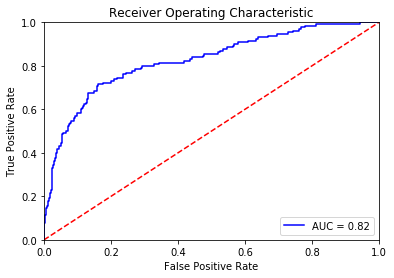

In [482]:
plot_roc_curve_with_auc(true_labels, pred_labels);

The ROC curve looks fine for this task

#### 5.2 Recall, F1, Precision and Accuracy

In [536]:
arr=[]
for threshold in np.arange(0, 1, 0.05):
    row = {}
    row['threshold'] = threshold
    pred_labels_thresholded = np.zeros_like(pred_labels)
    pred_labels_thresholded[pred_labels > threshold] = 1
    row['recall'] = recall_score(true_labels, pred_labels_thresholded)
    row['F1_score'] = f1_score(true_labels, pred_labels_thresholded)
    row['precision'] = precision_score(true_labels, pred_labels_thresholded)
    row['accuracy'] = accuracy_score(true_labels, pred_labels_thresholded)
    row['total_score'] = row['recall'] + row['accuracy'] + row['F1_score'] + row['precision']
    arr.append(row)
res_df = pd.DataFrame(arr)
res_df['total_normalized'] = (res_df.total_score - res_df.total_score.min())/(res_df.total_score.max()-res_df.total_score.min())
res_df.head(20)

,threshold,recall,F1_score,precision,accuracy,total_score,total_normalized
0,0.00,1.000000,0.225303,0.126953,0.126953,1.479210,0.000000
1,0.05,0.884615,0.308311,0.186688,0.496094,1.875708,0.408798
2,0.10,0.815385,0.359322,0.230435,0.630859,2.036001,0.574063
3,0.15,0.800000,0.413519,0.278820,0.711914,2.204253,0.747535
4,0.20,0.761538,0.445946,0.315287,0.759766,2.282537,0.828246
5,0.25,0.723077,0.479592,0.358779,0.800781,2.362229,0.910411
6,0.30,0.684615,0.500000,0.393805,0.826172,2.404593,0.954089
7,0.35,0.638462,0.507645,0.421320,0.842773,2.410200,0.959870
8,0.40,0.584615,0.510067,0.452381,0.857422,2.404485,0.953978
9,0.45,0.546154,0.505338,0.470199,0.864258,2.385948,0.934866


The most important score is Recall, since we don't want to miss any patient with suspected pneumonia. We also need to take into account other metrics to make sure that the prediction of the model is reliable

Let's visualize all metrics vs threshold.

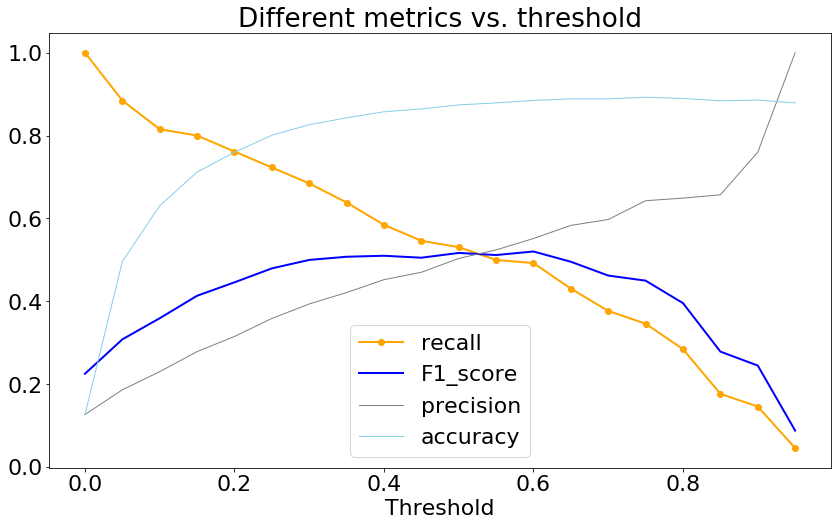

In [531]:
plt.figure(figsize=(14,8))
plt.title('Different metrics vs. threshold')
plt.xlabel('Threshold')
plt.plot('threshold', 'recall', data=res_df, marker='o', markerfacecolor='orange', color='orange', linewidth=2)
plt.plot('threshold', 'F1_score', data=res_df, color='blue', linewidth=2)
plt.plot('threshold', 'precision', data=res_df, color='grey', linewidth=1)
plt.plot('threshold', 'accuracy', data=res_df, color='skyblue', linewidth=1)
plt.legend();

This plot doesn't say much. It's better to plot the total score and recall score.

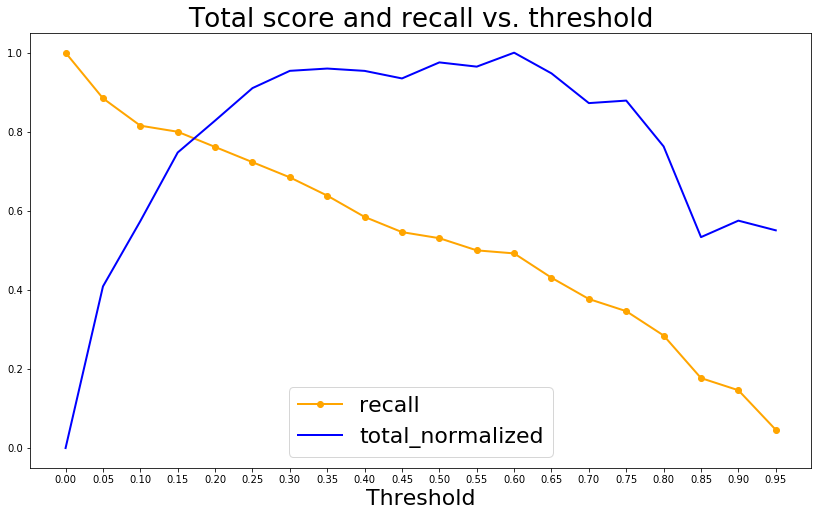

In [540]:
plt.figure(figsize=(14,8))
plt.title('Total score and recall vs. threshold')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, 1+0.05, 0.05))
plt.tick_params(labelsize=10)
plt.plot('threshold', 'recall', data=res_df, marker='o', markerfacecolor='orange', color='orange', linewidth=2)
plt.plot('threshold', 'total_normalized', data=res_df, color='blue', linewidth=2)
plt.legend();

#### 5.3. Setting threshold

Based on this plot, we can set two thresholds:

1. If we want to have highest recall while still keeping relatively high total score, we should pick threshold around 0.17
2. If we want to maximize total score while still keeping high recall, the threshold should be around 0.28

#### Additional plots

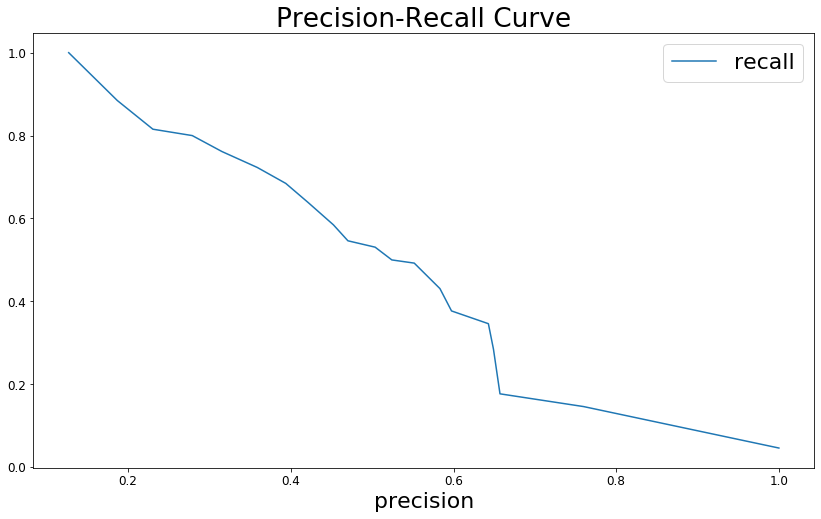

In [514]:
plt.rcParams.update({'font.size': 22})
res_df.plot(x='precision', y='recall', title='Precision-Recall Curve', figsize=(14,8), fontsize=12);

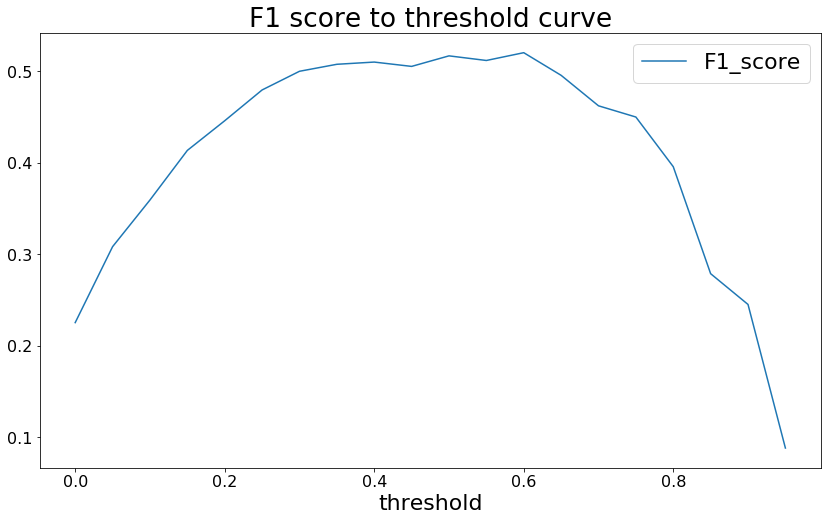

In [507]:
res_df.plot(x='threshold', y='F1_score', title='F1 score to threshold curve', figsize=(14,8), fontsize=16);